In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge transactions with products to get the category for each product
transactions = pd.merge(transactions, products[['ProductID', 'Category']], on="ProductID", how="left")

# Data preprocessing
# Step 1: Aggregating transaction data
transaction_features = transactions.groupby("CustomerID").agg({
    "TotalValue": "mean",  # Average transaction value
    "TransactionID": "count",  # Purchase frequency
    "Category": lambda x: x.value_counts().idxmax(),  # Dominant product category
    "ProductID": lambda x: x.nunique()  # Number of distinct products purchased
}).rename(columns={
    "TotalValue": "AvgTransactionValue",
    "TransactionID": "PurchaseFrequency",
    "Category": "DominantProductCategory",
    "ProductID": "DistinctProductCount"
})

# Merge aggregated transaction features with customer data
data = pd.merge(customers, transaction_features, on="CustomerID", how="left")

# Handle missing values
data.fillna({
    "AvgTransactionValue": data["AvgTransactionValue"].mean(),
    "PurchaseFrequency": 0,
    "DominantProductCategory": "Unknown",
    "DistinctProductCount": 0
}, inplace=True)

# Encode categorical features
data = pd.get_dummies(data, columns=["Region", "DominantProductCategory"], drop_first=True)

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ["AvgTransactionValue", "PurchaseFrequency", "DistinctProductCount"]
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Step 2: Clustering - DBSCAN
X = data[numerical_features + [col for col in data.columns if "Region_" in col or "DominantProductCategory_" in col]]

# Apply DBSCAN with chosen parameters
dbscan = DBSCAN(eps=0.4, min_samples=10)
data['Cluster'] = dbscan.fit_predict(X)

# Step 3: Clustering Metrics
# Calculate DB Index and Silhouette Score
# Since DBSCAN might assign -1 to noise points, we exclude them from silhouette score calculation
valid_clusters = data[data['Cluster'] != -1]
X_valid = valid_clusters[numerical_features + [col for col in valid_clusters.columns if "Region_" in col or "DominantProductCategory_" in col]]

# Calculate DB Index and Silhouette Score (for valid clusters)
db_index = davies_bouldin_score(X_valid, valid_clusters['Cluster'])
silhouette = silhouette_score(X_valid, valid_clusters['Cluster'])

# Print the evaluation metrics
print(f"DB Index: {db_index:.3f}")
print(f"Silhouette Score: {silhouette:.3f}")


DB Index: 0.381
Silhouette Score: 0.725


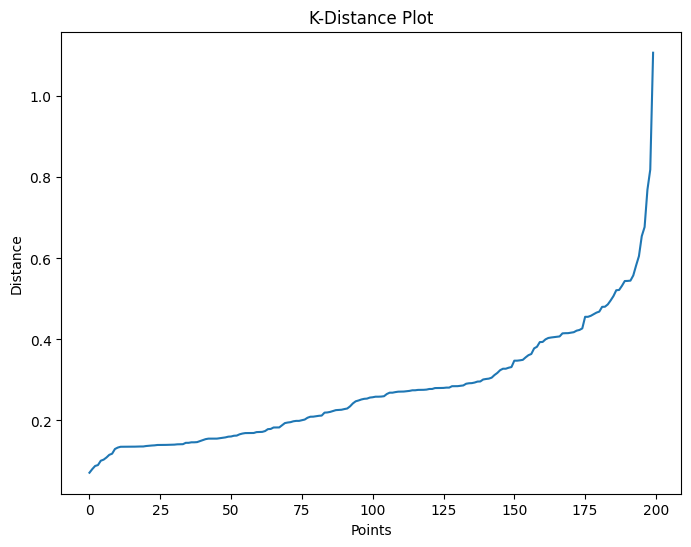

In [23]:
from sklearn.neighbors import NearestNeighbors

# Calculate K-distance plot
nbrs = NearestNeighbors(n_neighbors=4)
nbrs.fit(X)
distances, indices = nbrs.kneighbors(X)

# Sort distances to find the elbow point
distances = np.sort(distances[:, 3], axis=0)  # Sort the 4th nearest distance (since min_samples=4)
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title("K-Distance Plot")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()


K-Means DB Index: 1.428
K-Means Silhouette Score: 0.257


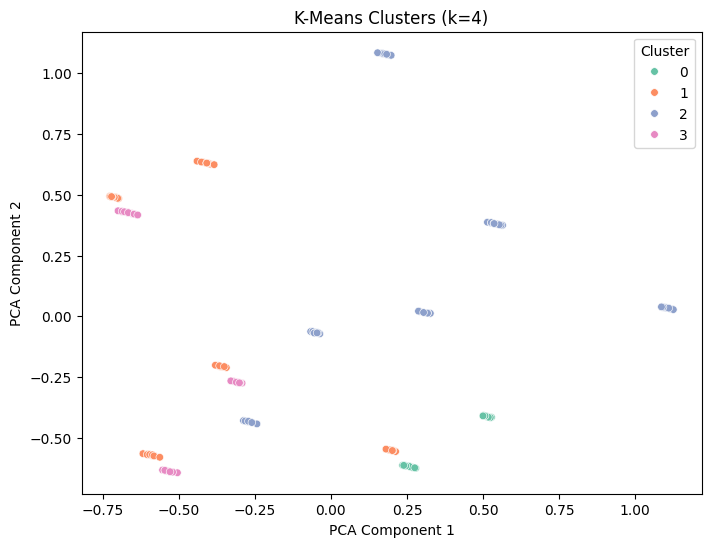

In [24]:
from sklearn.cluster import KMeans

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(X)


# Calculate DB Index and Silhouette Score for K-Means clusters
kmeans_db_index = davies_bouldin_score(X, data['KMeans_Cluster'])
kmeans_silhouette = silhouette_score(X, data['KMeans_Cluster'])

# Print the evaluation metrics for K-Means
print(f"K-Means DB Index: {kmeans_db_index:.3f}")
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")

# Reduce dimensionality using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot K-Means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=data['KMeans_Cluster'],
    palette="Set2",
    s=30
)
plt.title(f"K-Means Clusters (k={num_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()

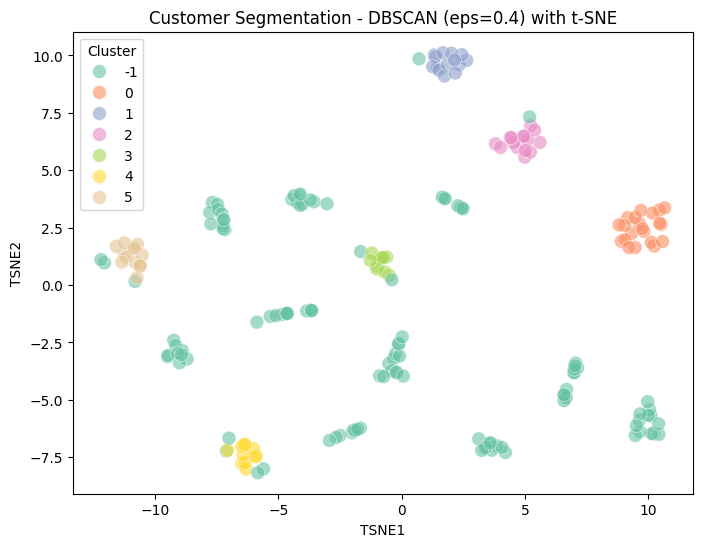

In [25]:
from sklearn.manifold import TSNE

# Reduce dimensions using t-SNE for better visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(X)

# Add t-SNE components to the dataframe
data['TSNE1'] = tsne_components[:, 0]
data['TSNE2'] = tsne_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=data, palette="Set2", s=100, alpha=0.6, edgecolor='w', linewidth=0.5)
plt.title("Customer Segmentation - DBSCAN (eps=0.4) with t-SNE")
plt.show()


In [26]:
from sklearn.preprocessing import StandardScaler

# StandardScaler for numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [27]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters= 4)
data['AggCluster'] = agg_clust.fit_predict(X)

# Evaluate using DB Index and Silhouette Score
agg_db_index = davies_bouldin_score(X, data['AggCluster'])
agg_silhouette = silhouette_score(X, data['AggCluster'])
print(f"Agglomerative DB Index: {agg_db_index:.3f}")
print(f"Agglomerative Silhouette Score: {agg_silhouette:.3f}")


Agglomerative DB Index: 1.515
Agglomerative Silhouette Score: 0.263


In [28]:
from sklearn.mixture import GaussianMixture

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_clusters = gmm.fit_predict(X)
data['GMMCluster'] = gmm_clusters

# Evaluate using DB Index and Silhouette Score
gmm_db_index = davies_bouldin_score(X, data['GMMCluster'])
gmm_silhouette = silhouette_score(X, data['GMMCluster'])
print(f"GMM DB Index: {gmm_db_index:.3f}")
print(f"GMM Silhouette Score: {gmm_silhouette:.3f}")


GMM DB Index: 1.396
GMM Silhouette Score: 0.273
